In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [83]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [84]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [85]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process A MIDI File

In [86]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--5.midi


In [87]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [88]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [89]:
display_audio(pm)

In [90]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [91]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [92]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,54,1.046875,1.506250,0.000000,0.459375
1,59,1.478125,1.868750,0.431250,0.390625
2,42,1.877083,2.266667,0.398958,0.389583
3,61,1.893750,2.308333,0.016667,0.414583
4,58,1.900000,2.313542,0.006250,0.413542


In [93]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F#3', 'B3', 'F#2', 'C#4', 'A#3', 'B2', 'D#4', 'B3', 'C#3', 'E4'],
      dtype='<U3')

In [94]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

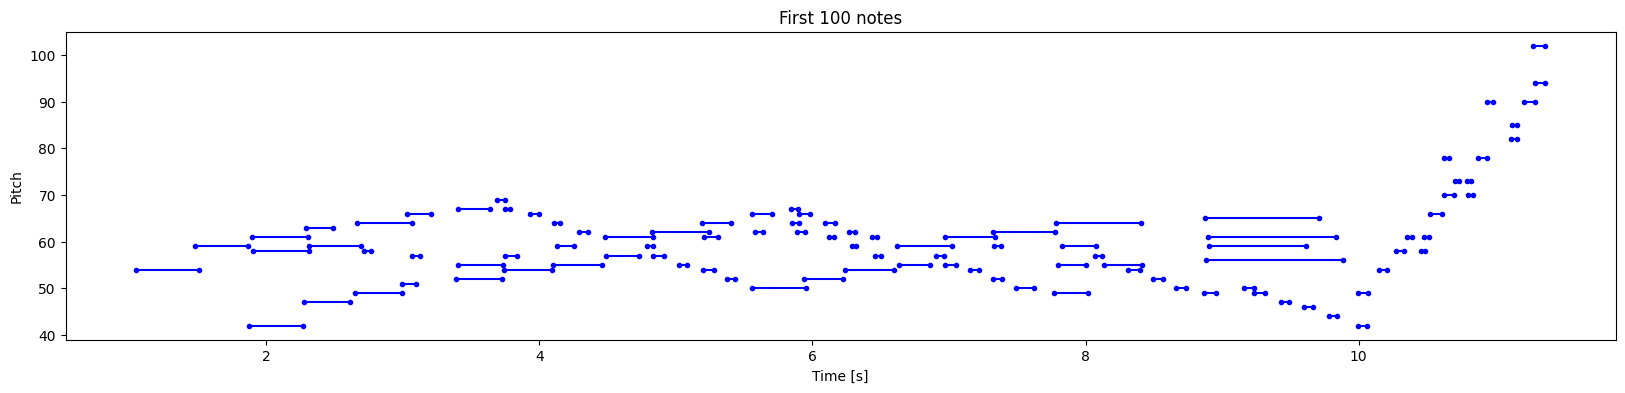

In [95]:
plot_piano_roll(raw_notes, count=100)

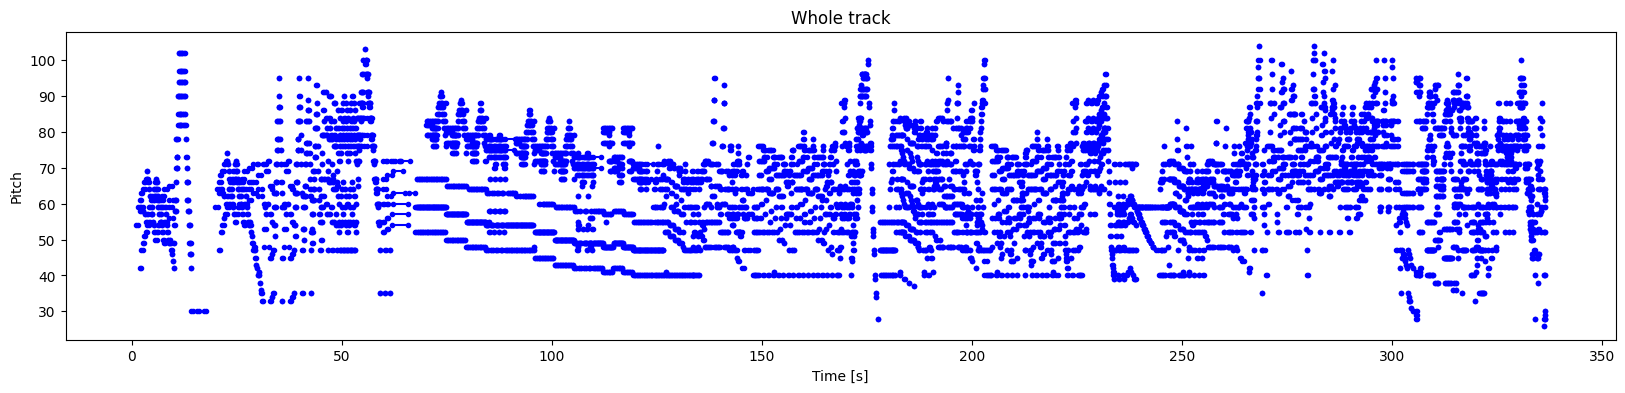

In [96]:
plot_piano_roll(raw_notes)

In [97]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

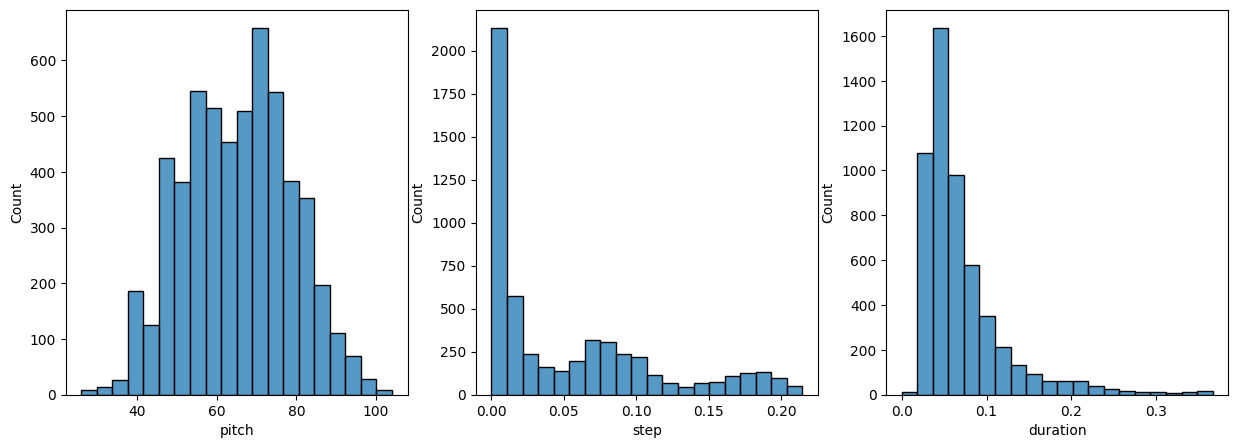

In [98]:
plot_distributions(raw_notes)

## Create a MIDI file

In [99]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [100]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [101]:
display_audio(example_pm)

## Create the training dataset

In [102]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [103]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 24525


In [104]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [105]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [106]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [107]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [108]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.4296875  0.         1.76875   ]
 [0.3984375  0.         1.875     ]
 [0.375      0.00416667 1.81979167]
 [0.5625     0.81458333 1.28333333]
 [0.5859375  1.28229167 0.0875    ]
 [0.578125   0.11770833 0.128125  ]
 [0.4296875  0.003125   1.9375    ]
 [0.390625   0.01041667 2.034375  ]
 [0.3671875  0.0125     1.95416667]
 [0.5234375  0.775      0.640625  ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=48.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.002083333333334103>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=2.0510416666666655>}


2024-04-06 20:47:32.080568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [109]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [110]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

In [111]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [112]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
losses = model.evaluate(train_ds, return_dict=True)
losses

382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 5.5753


2024-04-06 20:47:40.132433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 5.56533145904541}

In [114]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [115]:
model.evaluate(train_ds, return_dict=True)

382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.9678


2024-04-06 20:47:44.797318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


{'loss': 0.9699082970619202}

In [118]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [119]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.3298
Epoch 2/50
  3/382 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.2586

2024-04-06 20:51:56.897549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2983
Epoch 3/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2664

2024-04-06 20:52:06.265374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2936
Epoch 4/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.2644

2024-04-06 20:52:15.564533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2912
Epoch 5/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.2604

2024-04-06 20:52:24.826795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.2892
Epoch 6/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.2612

2024-04-06 20:52:35.801963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.2885
Epoch 7/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.2603

2024-04-06 20:52:47.120197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.2869
Epoch 8/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.2599

2024-04-06 20:52:57.213785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.2848
Epoch 9/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.2580 

2024-04-06 20:53:08.064005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.2839
Epoch 10/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.2593

2024-04-06 20:53:17.917521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.2833
Epoch 11/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.2563

2024-04-06 20:53:30.199837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.2799
Epoch 12/50
  3/382 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.2453

2024-04-06 20:53:40.255605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.2769
Epoch 13/50
  1/382 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.2383

2024-04-06 20:53:55.143656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.2765
Epoch 14/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.2545

2024-04-06 20:54:07.604017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.2738
Epoch 15/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.2551

2024-04-06 20:54:18.559557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.2729
Epoch 16/50
  3/382 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.2418

2024-04-06 20:54:29.428427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.2692
Epoch 17/50
  3/382 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.2469

2024-04-06 20:54:43.770606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.2674
Epoch 18/50
  3/382 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.2421

2024-04-06 20:54:58.585301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.2638
Epoch 19/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.2434

2024-04-06 20:55:09.421095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.2609
Epoch 20/50
  1/382 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 0.2294

2024-04-06 20:55:20.148877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - loss: 0.2605
Epoch 21/50
  3/382 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2313

2024-04-06 20:55:34.806547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.2577
Epoch 22/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.2400

2024-04-06 20:55:46.462376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.2541
Epoch 23/50
  3/382 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 0.2316

2024-04-06 20:55:57.287448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.2510
Epoch 24/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2380 

2024-04-06 20:56:07.526731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2488
Epoch 25/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.2354

2024-04-06 20:56:16.785893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.2471
Epoch 26/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.2332

2024-04-06 20:56:26.627791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.2437
Epoch 27/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.2342 

2024-04-06 20:56:36.263658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.2421
Epoch 28/50
  3/382 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.2209

2024-04-06 20:56:46.125390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.2400
Epoch 29/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.2287

2024-04-06 20:56:57.399446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.2362
Epoch 30/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.2296 

2024-04-06 20:57:06.314569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.2345
Epoch 31/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.2271

2024-04-06 20:57:14.923706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.2345
Epoch 32/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2326

2024-04-06 20:57:23.391387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2331
Epoch 33/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.2245

2024-04-06 20:57:32.671377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.2295
Epoch 34/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.2214 

2024-04-06 20:57:41.536638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.2274
Epoch 35/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.2237

2024-04-06 20:57:50.167064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.2304
Epoch 36/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.2253

2024-04-06 20:57:59.147458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.2313
Epoch 37/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.2199

2024-04-06 20:58:07.414762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.2243
Epoch 38/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.2203

2024-04-06 20:58:15.850451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.2201
Epoch 39/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.2231 

2024-04-06 20:58:24.006258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.2250
Epoch 40/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.2249 

2024-04-06 20:58:34.222093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.2204
Epoch 41/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.2165

2024-04-06 20:58:42.818774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.2160
Epoch 42/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.2114

2024-04-06 20:58:51.153870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.2130
Epoch 43/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2129

2024-04-06 20:59:00.402962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.2106
Epoch 44/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2164

2024-04-06 20:59:08.582568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.2130
Epoch 45/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.2159

2024-04-06 20:59:16.460442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.2135
Epoch 46/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.2163

2024-04-06 20:59:24.322670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.2108
Epoch 47/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.2151

2024-04-06 20:59:33.255244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.2074
Epoch 48/50
  7/382 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.2048

2024-04-06 20:59:40.811695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.2063
Epoch 49/50
  6/382 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.2093

2024-04-06 20:59:48.344528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.2056
Epoch 50/50
  5/382 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.2134

2024-04-06 20:59:56.198194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.2058
Restoring model weights from the end of the best epoch: 50.
CPU times: user 22min 26s, sys: 6min 54s, total: 29min 20s
Wall time: 8min 19s


2024-04-06 21:00:04.857588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


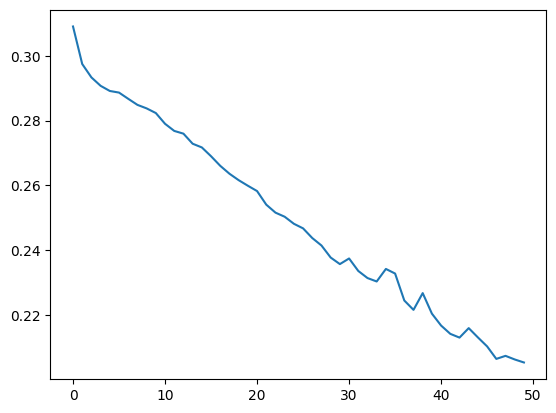

In [120]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [121]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [128]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [129]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,53,0.189933,0.217177,0.189933,0.407110
1,48,0.034201,0.466688,0.224134,0.690822
2,83,0.000969,0.525225,0.225103,0.750328
3,81,0.000000,0.558970,0.225103,0.784073
4,78,0.000000,0.554080,0.225103,0.779183
5,70,0.000000,0.557673,0.225103,0.782776
6,86,0.000000,0.572878,0.225103,0.797981
7,54,0.000000,0.558478,0.225103,0.783580
8,70,0.000000,0.567428,0.225103,0.792531
9,57,0.000112,0.584789,0.225215,0.810004


In [130]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

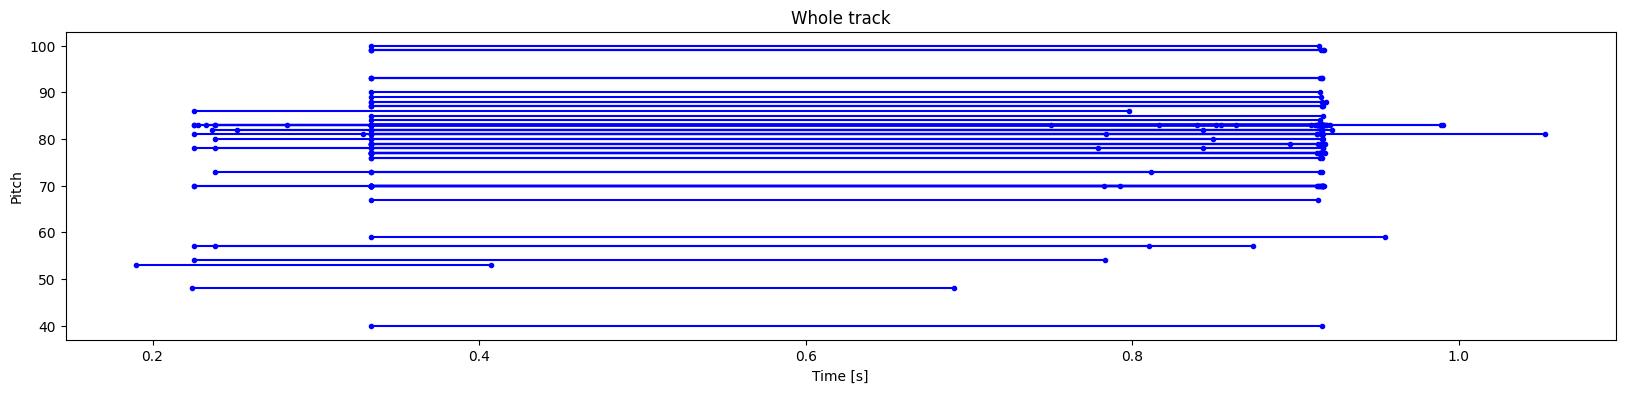

In [132]:
plot_piano_roll(generated_notes)

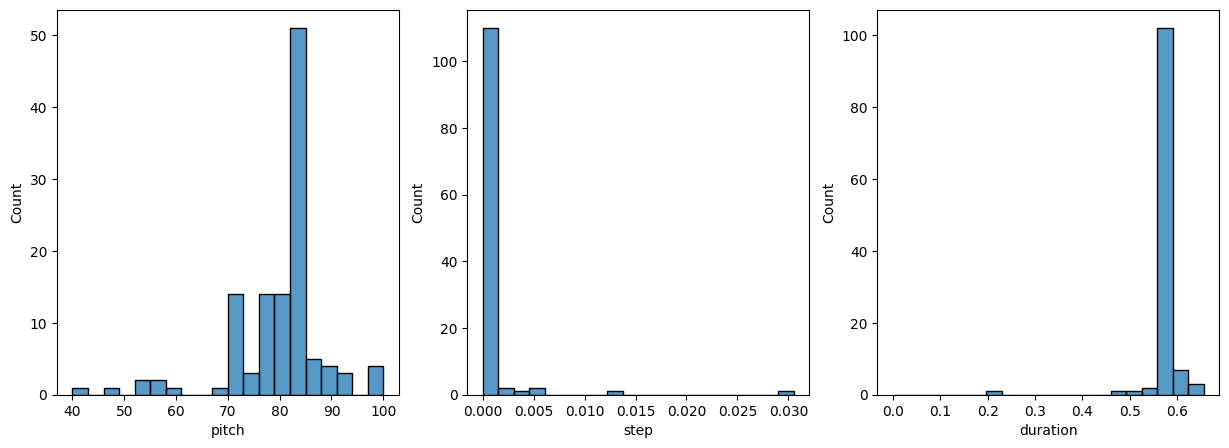

In [133]:
plot_distributions(generated_notes)